# Clustering: Sammon Mapping  

📌 Goal of Sammon Mapping  

> Sammon mapping is a non-linear dimensionality reduction technique. Like t-SNE, it maps high-dimensional data into a lower-dimensional space (typically 2D), but its objective is different:

Sammon Mapping tries to preserve the pairwise distances between data points, focusing especially on preserving small distances (local structure).  

✅ Dataset

| Point | Coordinates |
| ----- | ----------- |
| A     | (1, 1)      |
| B     | (2, 1)      |
| C     | (4, 3)      |
| D     | (5, 4)      |
| E     | (3, 4)      |

**Step 0: Compute Pairwise Distances in High-Dimensional Space**  

We use Euclidean distance between all pairs of points. Already computed:  

|   | A   | B   | C   | D   | E   |
| - | --- | --- | --- | --- | --- |
| A | 0.0 | 1.0 | 3.6 | 5.0 | 3.6 |
| B | 1.0 | 0.0 | 2.8 | 4.2 | 3.2 |
| C | 3.6 | 2.8 | 0.0 | 1.4 | 1.4 |
| D | 5.0 | 4.2 | 1.4 | 0.0 | 2.0 |
| E | 3.6 | 3.2 | 1.4 | 2.0 | 0.0 |

Let’s denote the original distance between points $i$ and $d_{ij}$.  


**Step 1: Initialize Low-Dimensional Points Randomly**  

We randomly assign initial 2D coordinates to each point, denoted $y_i \in R^2$. These will be updated iteratively.  

| Point | Initial $y$ (2D) |
| ----- | ---------------- |
| A     | (0.2, 0.5)       |
| B     | (0.3, 0.6)       |
| C     | (0.8, 0.4)       |
| D     | (1.0, 0.2)       |
| E     | (0.7, 0.9)       |

Let’s denote the projected distance in 2D as $d'_{ij} = ||y_i - y_j||$.  

**Step 2: Define the Sammon Stress Function**  

Sammon mapping minimizes the Sammon stress, which penalizes the difference between original and projected distances:  

$$E = \dfrac{1}{\sum_{i<j}d_{ij}}\sum_{i<j}\dfrac{(d'_{ij} - d_{ij})^2}{d_{ij}}$$  


Key properties:

* Small original distances $d_{ij}$ weigh more heavily.
* Focus is on preserving local distances.  
* The denominator $\sum_{i<j}d_{ij}$ is a constant normalization factor.  

This function is minimized using gradient descent.  


**Step 3: Compute Gradients and Update Positions**  

At each iteration:  
1. Compute the gradient $\dfrac{dE}{dy_i}$
2. Update the positions:  
$$y_i \leftarrow y_i - \eta.\dfrac{dE}{dy_i}$$  

Where:  
* $\eta$ is the learning rate
* The gradient pulls or pushes $y_i$ based on how much the current distance deviates from the target $d_{ij}$

This process repeats until convergence (when updates are small).

🧠 **Example: Stress from One Pair $(A, B)$**  

Let’s take the pair $A-B$:   

* Original distance: $d_{AB} = 1.0$
* Projected distance: suppose $d'_{AB} = 0.15$  

Then the contribution to the stress is:  

$$E_{AB} = \dfrac{(0.15 - 1.0)^2}{1.0} = 0.7225$$  

Now supposed $d'_{AD} = 4.9$ and $d_{AD} = 5.0$, then:  
$$E_{AD} = \dfrac{(4.9 - 5.0)^2}{5.0} = 0.002$$  

✅ This illustrates that errors on small distances hurt more. The optimizer will focus more on making close neighbors match.  

**Step 4: Iterative Minimization**  

We repeat:  

* Compute all $d_{ij}$ and $d'_{ij}$
* Evaluate the error function $E$
* Update all positions $y_i$

Convergence is reached when:

* The error stops decreasing
* Or a maximum number of iterations is reached

✅ **Why Use Sammon Mapping?**  

* Preserves local distances
* Good when geometric similarity is more important than density modeling
* Useful for interpreting cluster shapes or manifold unfolding.

✅ **Step-by-step Python code for Sammon mapping**

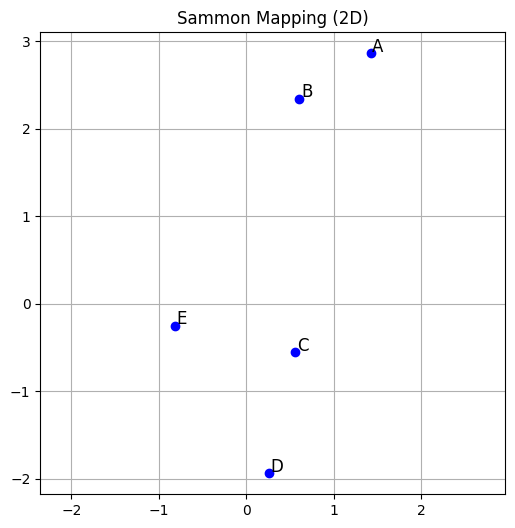

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def sammon_mapping(X, n_components=2, max_iter=500, tol=1e-9, alpha=0.3):
    """
    Simple Sammon mapping implementation (gradient descent-based).
    
    Parameters:
        X: array-like, shape (n_samples, n_features) - the original data
        n_components: int - target dimension (usually 2)
        max_iter: int - number of iterations
        tol: float - convergence tolerance
        alpha: float - learning rate
    Returns:
        Y: array-like, shape (n_samples, n_components) - low-dimensional embedding
    """
    n = X.shape[0]
    D_high = squareform(pdist(X))  # Euclidean distance matrix in high-dimensional space
    D_high[D_high == 0] = 1e-12    # Avoid division by zero

    # Initialize Y randomly (can also use PCA)
    rng = np.random.RandomState(42)
    Y = rng.normal(size=(n, n_components))

    # Compute initial low-dimensional distances
    D_low = squareform(pdist(Y))
    D_low[D_low == 0] = 1e-12

    # Sammon stress function
    scale = np.sum(D_high)
    E = np.sum(((D_high - D_low) ** 2) / D_high) / scale

    for it in range(max_iter):
        dY = np.zeros_like(Y)
        for i in range(n):
            for j in range(n):
                if i != j:
                    diff = Y[i] - Y[j]
                    d = np.linalg.norm(diff)
                    d = max(d, 1e-12)
                    delta = (D_high[i, j] - d) / (D_high[i, j] * d)
                    dY[i] += delta * diff

        Y += alpha * dY

        D_low = squareform(pdist(Y))
        D_low[D_low == 0] = 1e-12
        E_new = np.sum(((D_high - D_low) ** 2) / D_high) / scale

        if np.abs(E - E_new) < tol:
            break
        E = E_new

    return Y

# -----------------------------
# 📌 Apply on your toy dataset
# -----------------------------
points = {
    'A': (1, 1),
    'B': (2, 1),
    'C': (4, 3),
    'D': (5, 4),
    'E': (3, 4)
}

labels = list(points.keys())
X = np.array([points[k] for k in labels])  # shape (5, 2)

Y = sammon_mapping(X, n_components=2)

# -----------------------------
# 🎯 Visualize result
# -----------------------------
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    plt.scatter(Y[i, 0], Y[i, 1], c='blue')
    plt.text(Y[i, 0]+0.02, Y[i, 1]+0.02, label, fontsize=12)
plt.title("Sammon Mapping (2D)")
plt.axis('equal')
plt.grid(True)
plt.show()


🧠 **Notes:**  

| Concept                    | Explanation                                                                                       |
| -------------------------- | ------------------------------------------------------------------------------------------------- |
| **Stress function**        | Measures how well the low-dimensional distances approximate the original ones                     |
| **Gradient descent**       | Iteratively updates point positions to reduce stress                                              |
| **Distance normalization** | Ensures that large distances don’t dominate the optimization                                      |
| **Preserves**              | Sammon mapping preserves **global and local** distances (unlike t-SNE which focuses on **local**) |


✅ **SammonMapping class (scikit-learn compatible)**

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

class SammonMapping(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, max_iter=500, tol=1e-9, learning_rate=0.3, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y=None):
        self.X_ = np.array(X)
        self.n_samples_ = self.X_.shape[0]
        self.D_high_ = squareform(pdist(self.X_))
        self.D_high_[self.D_high_ == 0] = 1e-12
        self.scale_ = np.sum(self.D_high_)
        return self

    def transform(self):
        rng = np.random.RandomState(self.random_state)
        Y = rng.normal(size=(self.n_samples_, self.n_components))

        D_high = self.D_high_
        D_low = squareform(pdist(Y))
        D_low[D_low == 0] = 1e-12
        E = np.sum(((D_high - D_low) ** 2) / D_high) / self.scale_

        for it in range(self.max_iter):
            dY = np.zeros_like(Y)
            for i in range(self.n_samples_):
                for j in range(self.n_samples_):
                    if i != j:
                        diff = Y[i] - Y[j]
                        d = np.linalg.norm(diff)
                        d = max(d, 1e-12)
                        delta = (D_high[i, j] - d) / (D_high[i, j] * d)
                        dY[i] += delta * diff

            Y += self.learning_rate * dY

            D_low = squareform(pdist(Y))
            D_low[D_low == 0] = 1e-12
            E_new = np.sum(((D_high - D_low) ** 2) / D_high) / self.scale_

            if np.abs(E - E_new) < self.tol:
                break
            E = E_new

        self.embedding_ = Y
        return Y

    def fit_transform(self, X, y=None):
        return self.fit(X).transform()

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

X, y = load_iris(return_X_y=True)
sammon = SammonMapping(n_components=2)
Y = sammon.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='viridis')
plt.title("Sammon Mapping (2D)")
plt.show()

/var/folders/tb/_m1wm0vd633_w2zg_9vw_19m0000gn/T/ipykernel_7150/913384732.py:47: RuntimeWarning: overflow encountered in divide
  E_new = np.sum(((D_high - D_low) ** 2) / D_high) / self.scale_
/Users/davidtbo/Library/Mobile Documents/com~apple~CloudDocs/AI/machine_learning/unsupervised_learning/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/tb/_m1wm0vd633_w2zg_9vw_19m0000gn/T/ipykernel_7150/913384732.py:49: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(E - E_new) < self.tol:
/var/folders/tb/_m1wm0vd633_w2zg_9vw_19m0000gn/T/ipykernel_7150/913384732.py:40: RuntimeWarning: invalid value encountered in scalar divide
  delta = (D_high[i, j] - d) / (D_high[i, j] * d)


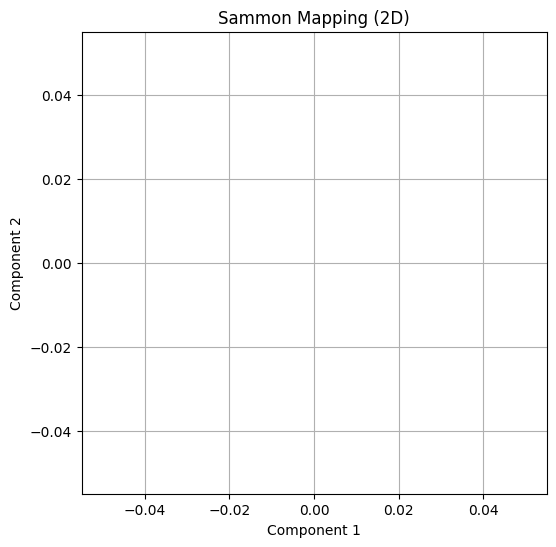

In [13]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

class SammonMapping(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, max_iter=500, tol=1e-9, learning_rate=0.3, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y=None):
        self.X_ = np.array(X)
        self.n_samples_ = self.X_.shape[0]
        self.D_high_ = squareform(pdist(self.X_))
        self.D_high_[self.D_high_ == 0] = 1e-12
        self.scale_ = np.sum(self.D_high_)
        return self

    def transform(self, X=None):
        rng = np.random.RandomState(self.random_state)
        Y = rng.normal(size=(self.n_samples_, self.n_components))

        D_high = self.D_high_
        D_low = squareform(pdist(Y))
        D_low[D_low == 0] = 1e-12
        E = np.sum(((D_high - D_low) ** 2) / D_high) / self.scale_

        for _ in range(self.max_iter):
            dY = np.zeros_like(Y)
            for i in range(self.n_samples_):
                for j in range(self.n_samples_):
                    if i != j:
                        diff = Y[i] - Y[j]
                        d = np.linalg.norm(diff)
                        d = max(d, 1e-12)
                        delta = (D_high[i, j] - d) / (D_high[i, j] * d)
                        dY[i] += delta * diff

            Y += self.learning_rate * dY

            D_low = squareform(pdist(Y))
            D_low[D_low == 0] = 1e-12
            E_new = np.sum(((D_high - D_low) ** 2) / D_high) / self.scale_

            if np.abs(E - E_new) < self.tol:
                break
            E = E_new

        self.embedding_ = Y
        return Y

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# === Load data and apply Sammon mapping ===
X, y = load_iris(return_X_y=True)
sammon = SammonMapping(n_components=2)
Y = sammon.fit_transform(X)

# === Plot the result ===
plt.figure(figsize=(6, 6))
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Sammon Mapping (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


/var/folders/tb/_m1wm0vd633_w2zg_9vw_19m0000gn/T/ipykernel_7150/913384732.py:47: RuntimeWarning: overflow encountered in divide
  E_new = np.sum(((D_high - D_low) ** 2) / D_high) / self.scale_
/var/folders/tb/_m1wm0vd633_w2zg_9vw_19m0000gn/T/ipykernel_7150/913384732.py:49: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(E - E_new) < self.tol:
/var/folders/tb/_m1wm0vd633_w2zg_9vw_19m0000gn/T/ipykernel_7150/913384732.py:40: RuntimeWarning: invalid value encountered in scalar divide
  delta = (D_high[i, j] - d) / (D_high[i, j] * d)


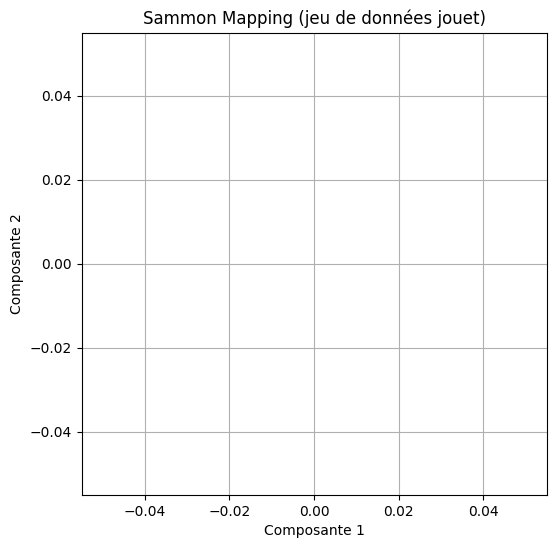

In [14]:
# Jeu de données jouet (3 clusters en 3D)
X = np.array([
    [1.0, 2.0, 3.0],
    [1.1, 2.1, 3.1],
    [0.9, 1.9, 2.9],
    [5.0, 5.0, 5.0],
    [5.1, 5.1, 5.1],
    [4.9, 4.9, 4.9],
    [8.0, 1.0, 2.0],
    [8.1, 1.1, 2.1],
    [7.9, 0.9, 1.9]
])

# Étiquettes factices pour la visualisation (3 groupes)
y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

# Appliquer Sammon Mapping
sammon = SammonMapping(n_components=2)
Y = sammon.fit_transform(X)

# Afficher le résultat
plt.figure(figsize=(6, 6))
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Sammon Mapping (jeu de données jouet)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.grid(True)
plt.show()
